In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [3]:
s = tf.Session()

In [4]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200
doc_embedding_size = 100
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)
window_size = 3     

save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

In [5]:
stops = []

valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

print('Loading Data')
texts, target = text_helpers.load_movie_data()

print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]    
assert(len(target)==len(texts))
print('Done.')

Loading Data
Normalizing Text Data
Done.


In [6]:
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

valid_examples = [word_dictionary[x] for x in valid_words]
print('Done.')

Creating Dictionary
Done.


In [7]:
print('Creating Model')
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
print('Done.')

Creating Model
Done.


In [8]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=final_embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
                                     
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

init = tf.global_variables_initializer()
s.run(init)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    s.run(train_step, feed_dict=feed_dict)

    if (i+1) % print_loss_every == 0:
        loss_val = s.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    if (i+1) % print_valid_every == 0:
        sim = s.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)

    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)

        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(s, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Loss at step 100 : 620.9815673828125
Loss at step 200 : 637.2611694335938
Loss at step 300 : 595.7765502929688
Loss at step 400 : 584.567138671875
Loss at step 500 : 565.8577880859375
Loss at step 600 : 518.1611938476562
Loss at step 700 : 493.01495361328125
Loss at step 800 : 522.7001342773438
Loss at step 900 : 487.7048645019531
Loss at step 1000 : 469.04913330078125
Loss at step 1100 : 465.0845642089844
Loss at step 1200 : 445.7919006347656
Loss at step 1300 : 448.2607421875
Loss at step 1400 : 465.92523193359375
Loss at step 1500 : 431.6545104980469
Loss at step 1600 : 403.1459655761719
Loss at step 1700 : 413.4204406738281
Loss at step 1800 : 409.69671630859375
Loss at step 1900 : 355.99688720703125
Loss at step 2000 : 367.7947692871094
Loss at step 2100 : 382.9486083984375
Loss at step 2200 : 358.06707763671875
Loss at step 2300 : 318.0557556152344
Loss at step 2400 : 340.4064025878906
Loss at step 2500 : 313.5778503417969
Loss at step 2600 : 304.9026184082031
Loss at step 2700 :

Loss at step 17800 : 55.888153076171875
Loss at step 17900 : 55.787689208984375
Loss at step 18000 : 51.478721618652344
Loss at step 18100 : 63.263797760009766
Loss at step 18200 : 48.15434265136719
Loss at step 18300 : 52.925968170166016
Loss at step 18400 : 67.5449447631836
Loss at step 18500 : 59.90597915649414
Loss at step 18600 : 53.566009521484375
Loss at step 18700 : 47.28288650512695
Loss at step 18800 : 57.26515579223633
Loss at step 18900 : 50.40507888793945
Loss at step 19000 : 42.01164245605469
Loss at step 19100 : 57.298561096191406
Loss at step 19200 : 39.411251068115234
Loss at step 19300 : 46.11396408081055
Loss at step 19400 : 61.875030517578125
Loss at step 19500 : 46.84326934814453
Loss at step 19600 : 42.69670486450195
Loss at step 19700 : 51.23670196533203
Loss at step 19800 : 56.02760696411133
Loss at step 19900 : 47.439453125
Loss at step 20000 : 44.28870391845703
Nearest to love: pauline, film, will, circumstances, wouldnt,
Nearest to hate: familiarity, pathetic

Loss at step 35100 : 38.12405776977539
Loss at step 35200 : 32.209991455078125
Loss at step 35300 : 45.10197448730469
Loss at step 35400 : 39.53693389892578
Loss at step 35500 : 36.62872314453125
Loss at step 35600 : 29.171215057373047
Loss at step 35700 : 38.725589752197266
Loss at step 35800 : 36.759273529052734
Loss at step 35900 : 34.93428039550781
Loss at step 36000 : 32.36042404174805
Loss at step 36100 : 40.67595672607422
Loss at step 36200 : 35.17350769042969
Loss at step 36300 : 37.406375885009766
Loss at step 36400 : 34.922523498535156
Loss at step 36500 : 28.512287139892578
Loss at step 36600 : 27.512479782104492
Loss at step 36700 : 30.58930778503418
Loss at step 36800 : 31.584701538085938
Loss at step 36900 : 29.066112518310547
Loss at step 37000 : 28.52118492126465
Loss at step 37100 : 38.257381439208984
Loss at step 37200 : 34.540924072265625
Loss at step 37300 : 27.146127700805664
Loss at step 37400 : 27.830039978027344
Loss at step 37500 : 23.903038024902344
Loss at st

Loss at step 52500 : 18.481773376464844
Loss at step 52600 : 28.756362915039062
Loss at step 52700 : 24.662290573120117
Loss at step 52800 : 25.818111419677734
Loss at step 52900 : 32.454490661621094
Loss at step 53000 : 24.391319274902344
Loss at step 53100 : 27.114999771118164
Loss at step 53200 : 24.830890655517578
Loss at step 53300 : 20.093229293823242
Loss at step 53400 : 26.1866512298584
Loss at step 53500 : 30.346426010131836
Loss at step 53600 : 28.504209518432617
Loss at step 53700 : 31.620738983154297
Loss at step 53800 : 27.757863998413086
Loss at step 53900 : 30.9392032623291
Loss at step 54000 : 21.75083351135254
Loss at step 54100 : 26.545494079589844
Loss at step 54200 : 30.629465103149414
Loss at step 54300 : 29.708032608032227
Loss at step 54400 : 23.76999282836914
Loss at step 54500 : 33.84529113769531
Loss at step 54600 : 25.325212478637695
Loss at step 54700 : 23.68126678466797
Loss at step 54800 : 22.635730743408203
Loss at step 54900 : 26.678653717041016
Loss at 

Loss at step 69800 : 23.21767807006836
Loss at step 69900 : 23.72572135925293
Loss at step 70000 : 26.50802993774414
Nearest to love: film, will, this, but, with,
Nearest to hate: familiarity, pathetic, terrific, pour, flamboyant,
Nearest to happy: benjamins, wollter, budget, ignore, wedding,
Nearest to sad: tenacious, bruckheimer, packs, definitely, spent,
Nearest to man: soderbergh, endings, changes, like, k,
Nearest to woman: total, suspect, uncompromising, head, contrivance,
Model saved in file: /Users/minheo/ML/ml/temp/doc2vec_movie_embeddings.ckpt
Loss at step 70100 : 30.796340942382812
Loss at step 70200 : 18.38542938232422
Loss at step 70300 : 20.601425170898438
Loss at step 70400 : 23.304826736450195
Loss at step 70500 : 24.957759857177734
Loss at step 70600 : 22.827577590942383
Loss at step 70700 : 19.80307960510254
Loss at step 70800 : 24.546573638916016
Loss at step 70900 : 21.884775161743164
Loss at step 71000 : 18.78314971923828
Loss at step 71100 : 24.111459732055664
Los

Loss at step 86000 : 22.52233123779297
Loss at step 86100 : 26.554933547973633
Loss at step 86200 : 21.51833152770996
Loss at step 86300 : 20.919132232666016
Loss at step 86400 : 14.64530086517334
Loss at step 86500 : 16.647506713867188
Loss at step 86600 : 24.68766975402832
Loss at step 86700 : 27.393798828125
Loss at step 86800 : 15.300386428833008
Loss at step 86900 : 16.3957576751709
Loss at step 87000 : 23.207544326782227
Loss at step 87100 : 18.41482162475586
Loss at step 87200 : 26.25054168701172
Loss at step 87300 : 19.715314865112305
Loss at step 87400 : 17.864227294921875
Loss at step 87500 : 24.150667190551758
Loss at step 87600 : 21.8911075592041
Loss at step 87700 : 18.767215728759766
Loss at step 87800 : 22.69956398010254
Loss at step 87900 : 14.440604209899902
Loss at step 88000 : 18.462886810302734
Loss at step 88100 : 19.562307357788086
Loss at step 88200 : 23.748733520507812
Loss at step 88300 : 19.0627498626709
Loss at step 88400 : 26.305858612060547
Loss at step 885

In [10]:
max_words = 20
logistic_batch_size = 500

In [11]:
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [12]:
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(log_final_embed, A), b)

In [13]:
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

init = tf.global_variables_initializer()
s.run(init)

In [14]:
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    s.run(logistic_train_step, feed_dict=feed_dict)

    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = s.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = s.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = s.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = s.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 6.80 (7.96). Train Acc (Test Acc): 0.55 (0.48)
Generation # 1000. Train Loss (Test Loss): 4.87 (5.17). Train Acc (Test Acc): 0.55 (0.51)
Generation # 1500. Train Loss (Test Loss): 3.42 (3.83). Train Acc (Test Acc): 0.53 (0.53)
Generation # 2000. Train Loss (Test Loss): 2.75 (3.17). Train Acc (Test Acc): 0.55 (0.52)
Generation # 2500. Train Loss (Test Loss): 2.65 (2.49). Train Acc (Test Acc): 0.52 (0.55)
Generation # 3000. Train Loss (Test Loss): 2.18 (2.52). Train Acc (Test Acc): 0.57 (0.53)
Generation # 3500. Train Loss (Test Loss): 2.42 (2.93). Train Acc (Test Acc): 0.61 (0.57)
Generation # 4000. Train Loss (Test Loss): 2.98 (3.23). Train Acc (Test Acc): 0.56 (0.54)
Generation # 4500. Train Loss (Test Loss): 2.63 (2.48). Train Acc (Test Acc): 0.53 (0.58)
Generation # 5000. Train Loss (Test Loss): 3.16 (3.23). Train Acc (Test Acc): 0.57 (0.55)
Generation # 5500. Train Loss (Test Loss): 2.39 (2.65). Trai

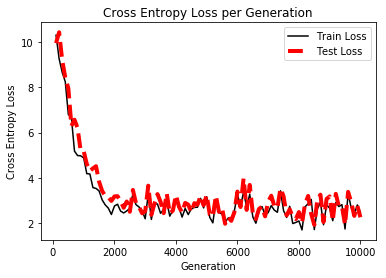

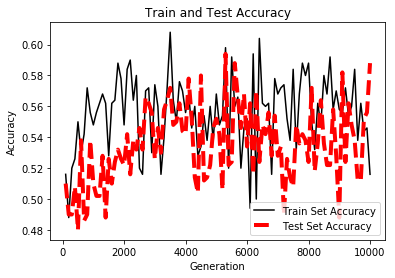

In [15]:
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()